In [2]:
import ot
import sgw
import scanpy as sc
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])

In [4]:
import plotly 
plotly_colors = plotly.colors.qualitative.Plotly

In [5]:
name = "real/silver/mouse-cell-atlas-combination-4"
adata = sc.read_h5ad('./data/adata.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 1222 × 2288
    uns: 'milestone_network'
    obsm: 'milestone_percentages'

In [7]:
ms_names = np.array(adata.obsm['milestone_percentages'].columns.values, str)
adata.obs['milestones'] = pd.Series(list(ms_names[np.argmax(adata.obsm['milestone_percentages'],axis=1)]), dtype="category").values

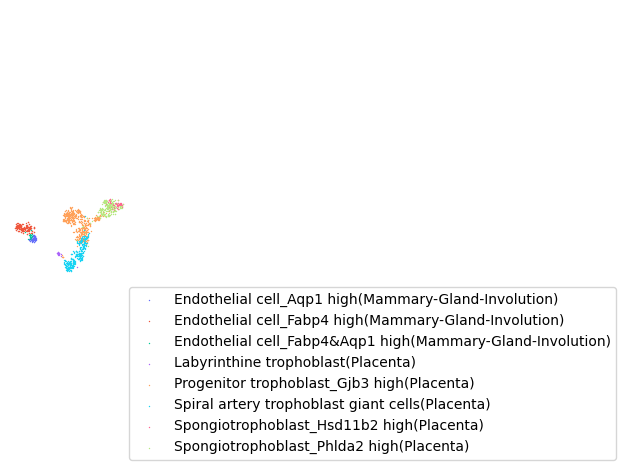

In [8]:
n_pcs = 20
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.tsne(adata, n_pcs=n_pcs)
X_tsne = adata.obsm['X_tsne']
# sc.tl.umap(adata)
milestones = np.sort(list(set(adata.obs['milestones'])))
for i in range(len(milestones)):
    idx = np.where(adata.obs['milestones']==milestones[i])[0]
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], c=plotly_colors[i], label=milestones[i], s=1, linewidth=0)
plt.legend(loc=[1.01,0])
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig("./figures/scatter_dataset.pdf")

In [9]:
set(adata.obs['milestones'])

{'Endothelial cell_Aqp1 high(Mammary-Gland-Involution)',
 'Endothelial cell_Fabp4 high(Mammary-Gland-Involution)',
 'Endothelial cell_Fabp4&Aqp1 high(Mammary-Gland-Involution)',
 'Labyrinthine trophoblast(Placenta)',
 'Progenitor trophoblast_Gjb3 high(Placenta)',
 'Spiral artery trophoblast giant cells(Placenta)',
 'Spongiotrophoblast_Hsd11b2 high(Placenta)',
 'Spongiotrophoblast_Phlda2 high(Placenta)'}

In [10]:
X_pca = adata.obsm['X_pca'][:,:20]
# X_pca = adata.obsm['X_tsne']

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
A = adata.obsp['distances']
G = nx.from_numpy_array(A)
ncell = A.shape[0]

In [12]:
p = dict(nx.shortest_path_length(G, weight='weight'))

In [13]:
D = np.array([[p[i][j] for i in range(ncell)] for j in range(ncell)])

In [14]:
adata.obsp['geodesics'] = D

In [15]:
idx = sgw.downsample_data(X_pca[:,:3], method='mapper', km_n_cubes=10, km_perc_overlap=0.2)
print(len(idx))

89


In [16]:
adata_sub = adata[idx,:].copy()

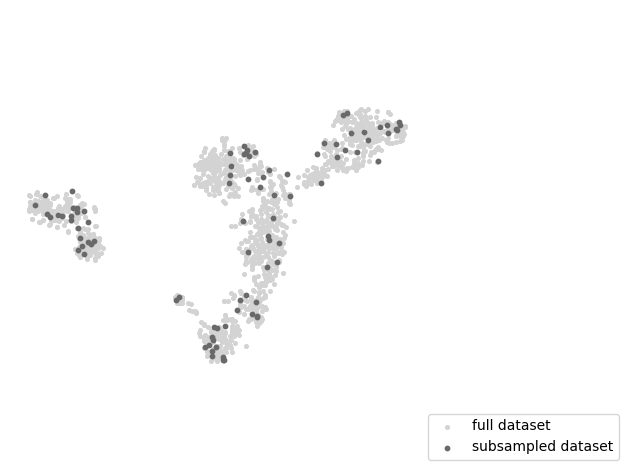

In [20]:
plt.scatter(adata.obsm['X_tsne'][:,0], adata.obsm['X_tsne'][:,1], label='full dataset', c='lightgrey', s=7)
plt.scatter(adata_sub.obsm['X_tsne'][:,0], adata_sub.obsm['X_tsne'][:,1], label='subsampled dataset', s=10, c='dimgrey')
plt.legend(loc=[1.01,0])
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig("./figures/scatter_mapper.pdf")

## Mostly overlapping

In [21]:
milestone_set_1 = ['Endothelial cell_Aqp1 high(Mammary-Gland-Involution)',
 'Endothelial cell_Fabp4&Aqp1 high(Mammary-Gland-Involution)',
 'Labyrinthine trophoblast(Placenta)',
 'Progenitor trophoblast_Gjb3 high(Placenta)',
 'Spiral artery trophoblast giant cells(Placenta)',
 'Spongiotrophoblast_Hsd11b2 high(Placenta)',
 'Spongiotrophoblast_Phlda2 high(Placenta)']

milestone_set_2 = ['Endothelial cell_Aqp1 high(Mammary-Gland-Involution)',
 'Endothelial cell_Fabp4 high(Mammary-Gland-Involution)',
 'Endothelial cell_Fabp4&Aqp1 high(Mammary-Gland-Involution)',
 'Labyrinthine trophoblast(Placenta)',
 'Progenitor trophoblast_Gjb3 high(Placenta)',
 'Spiral artery trophoblast giant cells(Placenta)']

In [22]:
adata_sub = adata[idx]
adata_sub_1 = adata_sub[adata_sub.obs['milestones'].isin(milestone_set_1),:]
adata_sub_2 = adata_sub[adata_sub.obs['milestones'].isin(milestone_set_2),:]
adata_1 = adata[adata.obs['milestones'].isin(milestone_set_1),:]
adata_2 = adata[adata.obs['milestones'].isin(milestone_set_2),:]

In [23]:
D_1 = adata_sub_1.obsp['geodesics']
D_2 = adata_sub_2.obsp['geodesics']
X_1 = adata_sub_1.obsm['X_tsne']
X_2 = adata_sub_2.obsm['X_tsne']
print(D_1.shape, D_2.shape)

(74, 74) (71, 71)


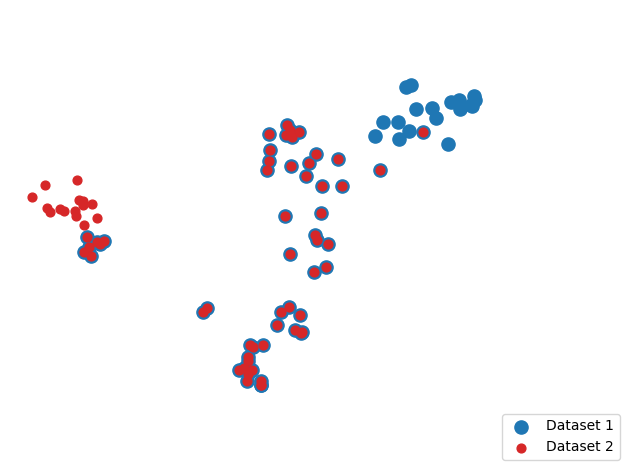

In [25]:
plt.scatter(adata_sub_1.obsm['X_tsne'][:,0], adata_sub_1.obsm['X_tsne'][:,1], label='Dataset 1', c='tab:blue', s=90)
plt.scatter(adata_sub_2.obsm['X_tsne'][:,0], adata_sub_2.obsm['X_tsne'][:,1], label='Dataset 2', c='tab:red', s=40)
plt.legend(loc=[1.01,0])
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig("./figures/scatter_downsample_twodatasets.pdf")

In [24]:
P = sgw.supervised_gromov_wasserstein(D_1, D_2, nitermax=20, threshold=10)

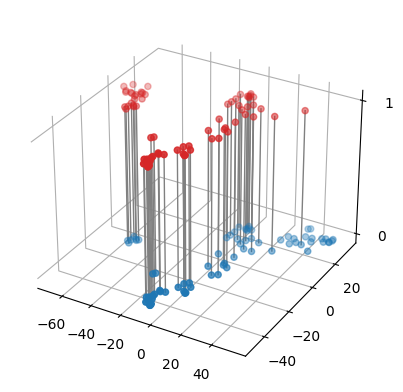

In [36]:
plot_mapping(P, X_1, X_2, thresh=0.01/X_2.shape[0])
plt.savefig('./figures/coupling_partialoverlap_downsample.pdf')

In [28]:
DD1 = adata_1.obsp['geodesics'][:,[np.where(adata_1.obs_names==adata_sub_1.obs_names[i])[0][0] for i in range(adata_sub_1.shape[0])]]
DD2 = adata_2.obsp['geodesics'][:,[np.where(adata_2.obs_names==adata_sub_2.obs_names[i])[0][0] for i in range(adata_sub_2.shape[0])]]

In [32]:
P_full = sgw.recover_full_coupling(P,DD1,DD2,delta=0.7, thresh=5, eps=0.01, nitermax=10000000)

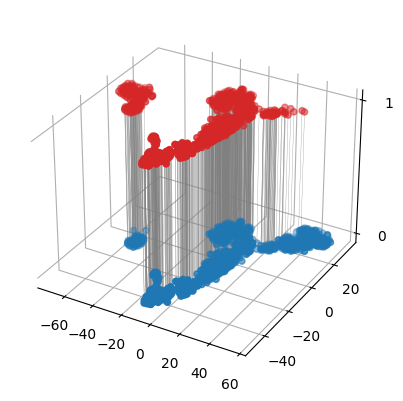

In [37]:
plot_mapping(P_full.toarray(),adata_1.obsm['X_tsne'], adata_2.obsm['X_tsne'], thresh=0.00000001, linewidth=0.2)
plt.savefig('./figures/coupling_partialoverlap_full.pdf')

## Slightly overlapping

In [38]:
milestone_set_1 = ['Endothelial cell_Aqp1 high(Mammary-Gland-Involution)',
 'Labyrinthine trophoblast(Placenta)',
 'Progenitor trophoblast_Gjb3 high(Placenta)',
 'Spiral artery trophoblast giant cells(Placenta)',
 'Endothelial cell_Fabp4&Aqp1 high(Mammary-Gland-Involution)',
 'Endothelial cell_Fabp4 high(Mammary-Gland-Involution)']

milestone_set_2 = [
 'Progenitor trophoblast_Gjb3 high(Placenta)',
 'Spongiotrophoblast_Hsd11b2 high(Placenta)',
 'Spongiotrophoblast_Phlda2 high(Placenta)']

In [39]:
adata_sub = adata[idx]
adata_sub_1 = adata_sub[adata_sub.obs['milestones'].isin(milestone_set_1),:]
adata_sub_2 = adata_sub[adata_sub.obs['milestones'].isin(milestone_set_2),:]
adata_1 = adata[adata.obs['milestones'].isin(milestone_set_1),:]
adata_2 = adata[adata.obs['milestones'].isin(milestone_set_2),:]

In [40]:
D_1 = adata_sub_1.obsp['geodesics']
D_2 = adata_sub_2.obsp['geodesics']
X_1 = adata_sub_1.obsm['X_tsne']
X_2 = adata_sub_2.obsm['X_tsne']
print(D_1.shape, D_2.shape)

(71, 71) (41, 41)


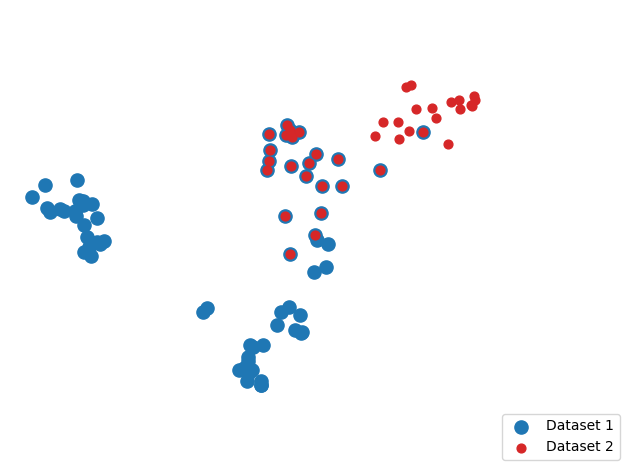

In [41]:
plt.scatter(adata_sub_1.obsm['X_tsne'][:,0], adata_sub_1.obsm['X_tsne'][:,1], label='Dataset 1', c='tab:blue', s=90)
plt.scatter(adata_sub_2.obsm['X_tsne'][:,0], adata_sub_2.obsm['X_tsne'][:,1], label='Dataset 2', c='tab:red', s=40)
plt.legend(loc=[1.01,0])
plt.axis('off')
plt.axis('equal')
plt.tight_layout()
plt.savefig("./figures/scatter_downsample_twodatasets_slightoverlap.pdf")

In [46]:
P = sgw.supervised_gromov_wasserstein(D_1, D_2, nitermax=20, threshold=1)

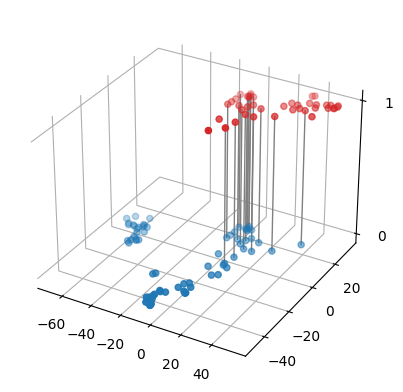

In [47]:
plot_mapping(P, X_1, X_2, thresh=0.01/X_2.shape[0])
plt.savefig('./figures/coupling_slightoverlap_downsample.pdf')

In [48]:
DD1 = adata_1.obsp['geodesics'][:,[np.where(adata_1.obs_names==adata_sub_1.obs_names[i])[0][0] for i in range(adata_sub_1.shape[0])]]
DD2 = adata_2.obsp['geodesics'][:,[np.where(adata_2.obs_names==adata_sub_2.obs_names[i])[0][0] for i in range(adata_sub_2.shape[0])]]

In [51]:
P_full = sgw.recover_full_coupling(P,DD1,DD2,delta=0.2, thresh=5, eps=0.01, nitermax=10000000)

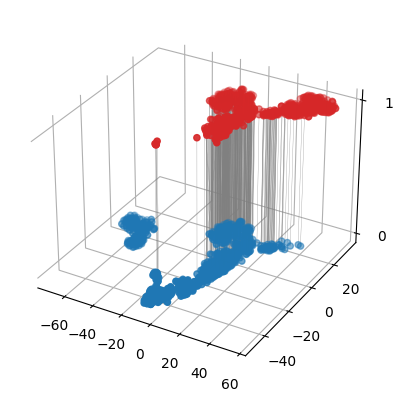

In [52]:
plot_mapping(P_full.toarray(),adata_1.obsm['X_tsne'], adata_2.obsm['X_tsne'], thresh=0.00000001, linewidth=0.2)
plt.savefig('./figures/coupling_slightoverlap_full.pdf')